# Psychedelic Therapies vs. ECT: Interactive Analysis

This notebook provides an interactive way to run the CEA model, load data, and visualize results.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
params = pd.read_csv('/Users/doughnut/Library/CloudStorage/OneDrive-NSWHealthDepartment/Project - EE - IV Ketamine vs ECT/data/parameters_psa.csv')
clin = pd.read_csv('/Users/doughnut/Library/CloudStorage/OneDrive-NSWHealthDepartment/Project - EE - IV Ketamine vs ECT/data/clinical_inputs.csv')
cost_au = pd.read_csv('/Users/doughnut/Library/CloudStorage/OneDrive-NSWHealthDepartment/Project - EE - IV Ketamine vs ECT/data/cost_inputs_au.csv')

def get_param(name, default=None):
    row = params[params['Parameter']==name]
    return float(row['BaseValue'].iloc[0]) if not row.empty else default

def cost_lookup_au(label):
    row = cost_au[cost_au['Item']==label]
    return float(row['AUD_Value_2024'].iloc[0]) if not row.empty else 0.0

utility_dep = get_param('Utility depressed', 0.57)
utility_rem = get_param('Utility remission', 0.81)
cost_ect_session = cost_lookup_au('ECT total session cost (public)')
cost_ket_session = cost_lookup_au('Ketamine total session (IV)')
cost_esk_session = cost_lookup_au('Esketamine session – assumed total')
cost_psilo_program = cost_lookup_au('Psilocybin program (2-dose + therapy)')

def simulate_strategy(strategy='ECT', horizon_months=120, cohort=1000):
    dep, rem = cohort, 0.0
    total_cost, total_qalys = 0.0, 0.0
    adherence = 1.0
    if strategy=='ECT': total_cost += 8*cost_ect_session; p_remit=0.60; adherence = get_param('ECT Adherence Rate', 1.0)
    elif strategy=='Ketamine': total_cost += 8*cost_ket_session; p_remit=0.45; adherence = get_param('Ketamine Adherence Rate', 1.0)
    elif strategy=='Esketamine': total_cost += 8*cost_esk_session; p_remit=0.36; adherence = get_param('Esketamine Adherence Rate', 1.0)
    elif strategy=='Psilocybin': total_cost += cost_psilo_program; p_remit=0.40; adherence = get_param('Psilocybin Adherence Rate', 1.0)
    else: p_remit=0.0
    p_remit *= adherence
    rem = dep*p_remit; dep -= rem
    for m in range(1, horizon_months+1):
        total_qalys += (dep*utility_dep + rem*utility_rem)/cohort/12.0
    return {'strategy':strategy,'cost':total_cost,'qalys':total_qalys}

print('Data loaded and functions defined.')

Data loaded and functions defined.


In [6]:
# Run simulations for all strategies
strategies = ['ECT', 'Ketamine', 'Esketamine', 'Psilocybin']
results = [simulate_strategy(s) for s in strategies]
df = pd.DataFrame(results)
print(df)

     strategy     cost  qalys
0         ECT   8000.0  7.140
1    Ketamine   2400.0  6.780
2  Esketamine   6400.0  6.564
3  Psilocybin  15000.0  6.660


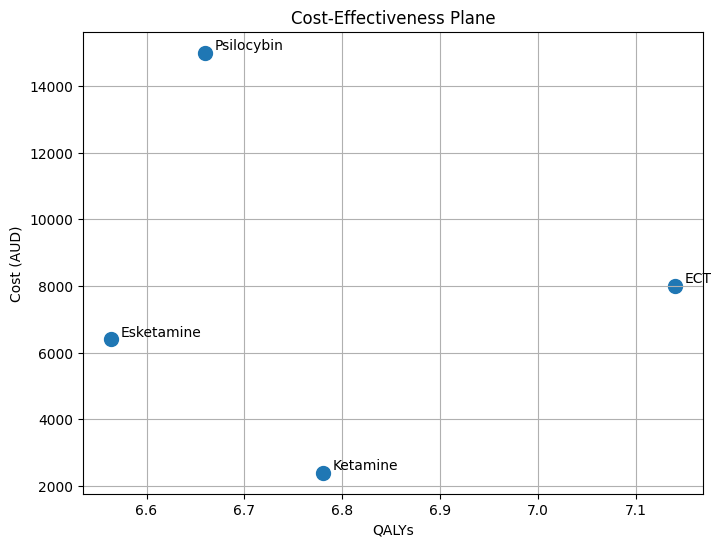

In [7]:
# Plot cost vs QALYs
plt.figure(figsize=(8,6))
plt.scatter(df['qalys'], df['cost'], s=100)
for i, row in df.iterrows():
    plt.text(row['qalys']+0.01, row['cost']+100, row['strategy'])
plt.xlabel('QALYs')
plt.ylabel('Cost (AUD)')
plt.title('Cost-Effectiveness Plane')
plt.grid(True)
plt.show()

## Notes
- Adjust horizon_months in simulate_strategy for different time horizons.
- Load PSA results from scripts/psa_results.csv for further analysis.